# Bayesian Calibration Using Alan's Processed Data

In this notebook, we do the full Bayesian calibration fit that *may* end up in the final paper, using data that went into the Nature Paper, processed by Alan. 

## Data Loading and Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from edges_cal import modelling as mdl
from pathlib import Path

import mcmc_utils as mutl
from edges_estimate.fitting import SemiLinearFit
from edges_cal.modelling import NoiseWaves, LinLog, Polynomial, UnitTransform
from yabf.core.samplers import run_map
from getdist import plots
import alan_data_utils as utils
import alan_data as adata
import run_alan_cal_mcmc as mcmc
import notebook_utils as nutl
from astropy import units as u
import pickle
import analyse_mcmc as anls

from edges_cal import receiver_calibration_func as rcf

from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.stats import gaussian_kde
plt.ion()
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
nutl.setup_mpl()

In [3]:
calobs32 = utils.get_calobs(smooth=32)
labcal32 = utils.get_labcal(calobs32)

In [5]:
cal_runs = mutl.get_completed_mcsamples(mcmc.mcdef.folder)

In [6]:
cal_runs.keys()

dict_keys(["c04_w05_smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_antsim-False", "c04_w05_smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_antsim-True", 'c04_w05_smooth32_tns0500_ign[()]_sim[()]_s11()_antsim-False', "c05_w05_smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_antsim-False", "c05_w05_smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_antsim-True", 'c05_w05_smooth32_tns0500_ign[()]_sim[()]_s11()_antsim-False', "c06_w04_smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_antsim-False", "c06_w04_smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_antsim-True", 'c06_w04_smooth32_tns0500_ign[()]_sim[()]_s11()_antsim-False', "c06_w05_cf03_wf05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsim-False", "c06_w05_cf04_wf05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsim-False", "c06_w05_cf05_wf05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsim-False", "c06_w05_cf06_wf04_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11(

In [7]:
cal_blobs = { 
    name: anls.get_all_cal_curves(mcsamples, mcmc.mcdef, field_freq=adata.sky_freq, force=False, nthreads=16) for name, mcsamples in cal_runs.items() if "sim[('" in name and 'c06' in name and 'cf06' in name and 'w05' in name
}

In [8]:
cal_blobs.keys()

dict_keys(["c06_w05_cf06_wf04_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsim-False", "c06_w05_cf06_wf05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsim-False", "c06_w05_cf06_wf06_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsim-False"])

## Dependence on C/W terms

In [13]:
antsim32 = calobs32.new_load("AntSim1", io_obj = calobs32.metadata['io'])
loads = {**calobs32.loads, **{'AntSim1': antsim32}}

In [9]:
for w in [4,5,6]:
    cr = f"c06_w05_cf06_wf{w:02}_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsim-False"
    ev = mutl.get_evidence('outputs/alan_cal/'+str(cr)+'/bayescal')
    print(w, ev)

4 -10065.451969506
5 3083.69629025183
6 3075.0858529685


In [10]:
for c in [3, 4,5,6, 7, 8 ,9]:
    cr = f"c06_w05_cf{c:02}_wf05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsim-False"
    ev = mutl.get_evidence('outputs/alan_cal/'+str(cr)+'/bayescal')
    print(c, ev)

3 -1787.61380309472
4 2944.69650952291
5 3029.07062524499
6 3083.69629025183
7 3075.37479854116
8 3068.21318751612
9 3062.16932938343


In [11]:
for c in [5,6, 7, 8 ,]:
    cr = f"c08_w05_cf{c:02}_wf05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsim-False"
    ev = mutl.get_evidence('outputs/alan_cal/'+str(cr)+'/bayescal')
    print(c, ev)

5 3014.66022244941
6 3078.68532506522
7 3072.77354683229
8 3068.29433211908


## Posterior For Best Solution

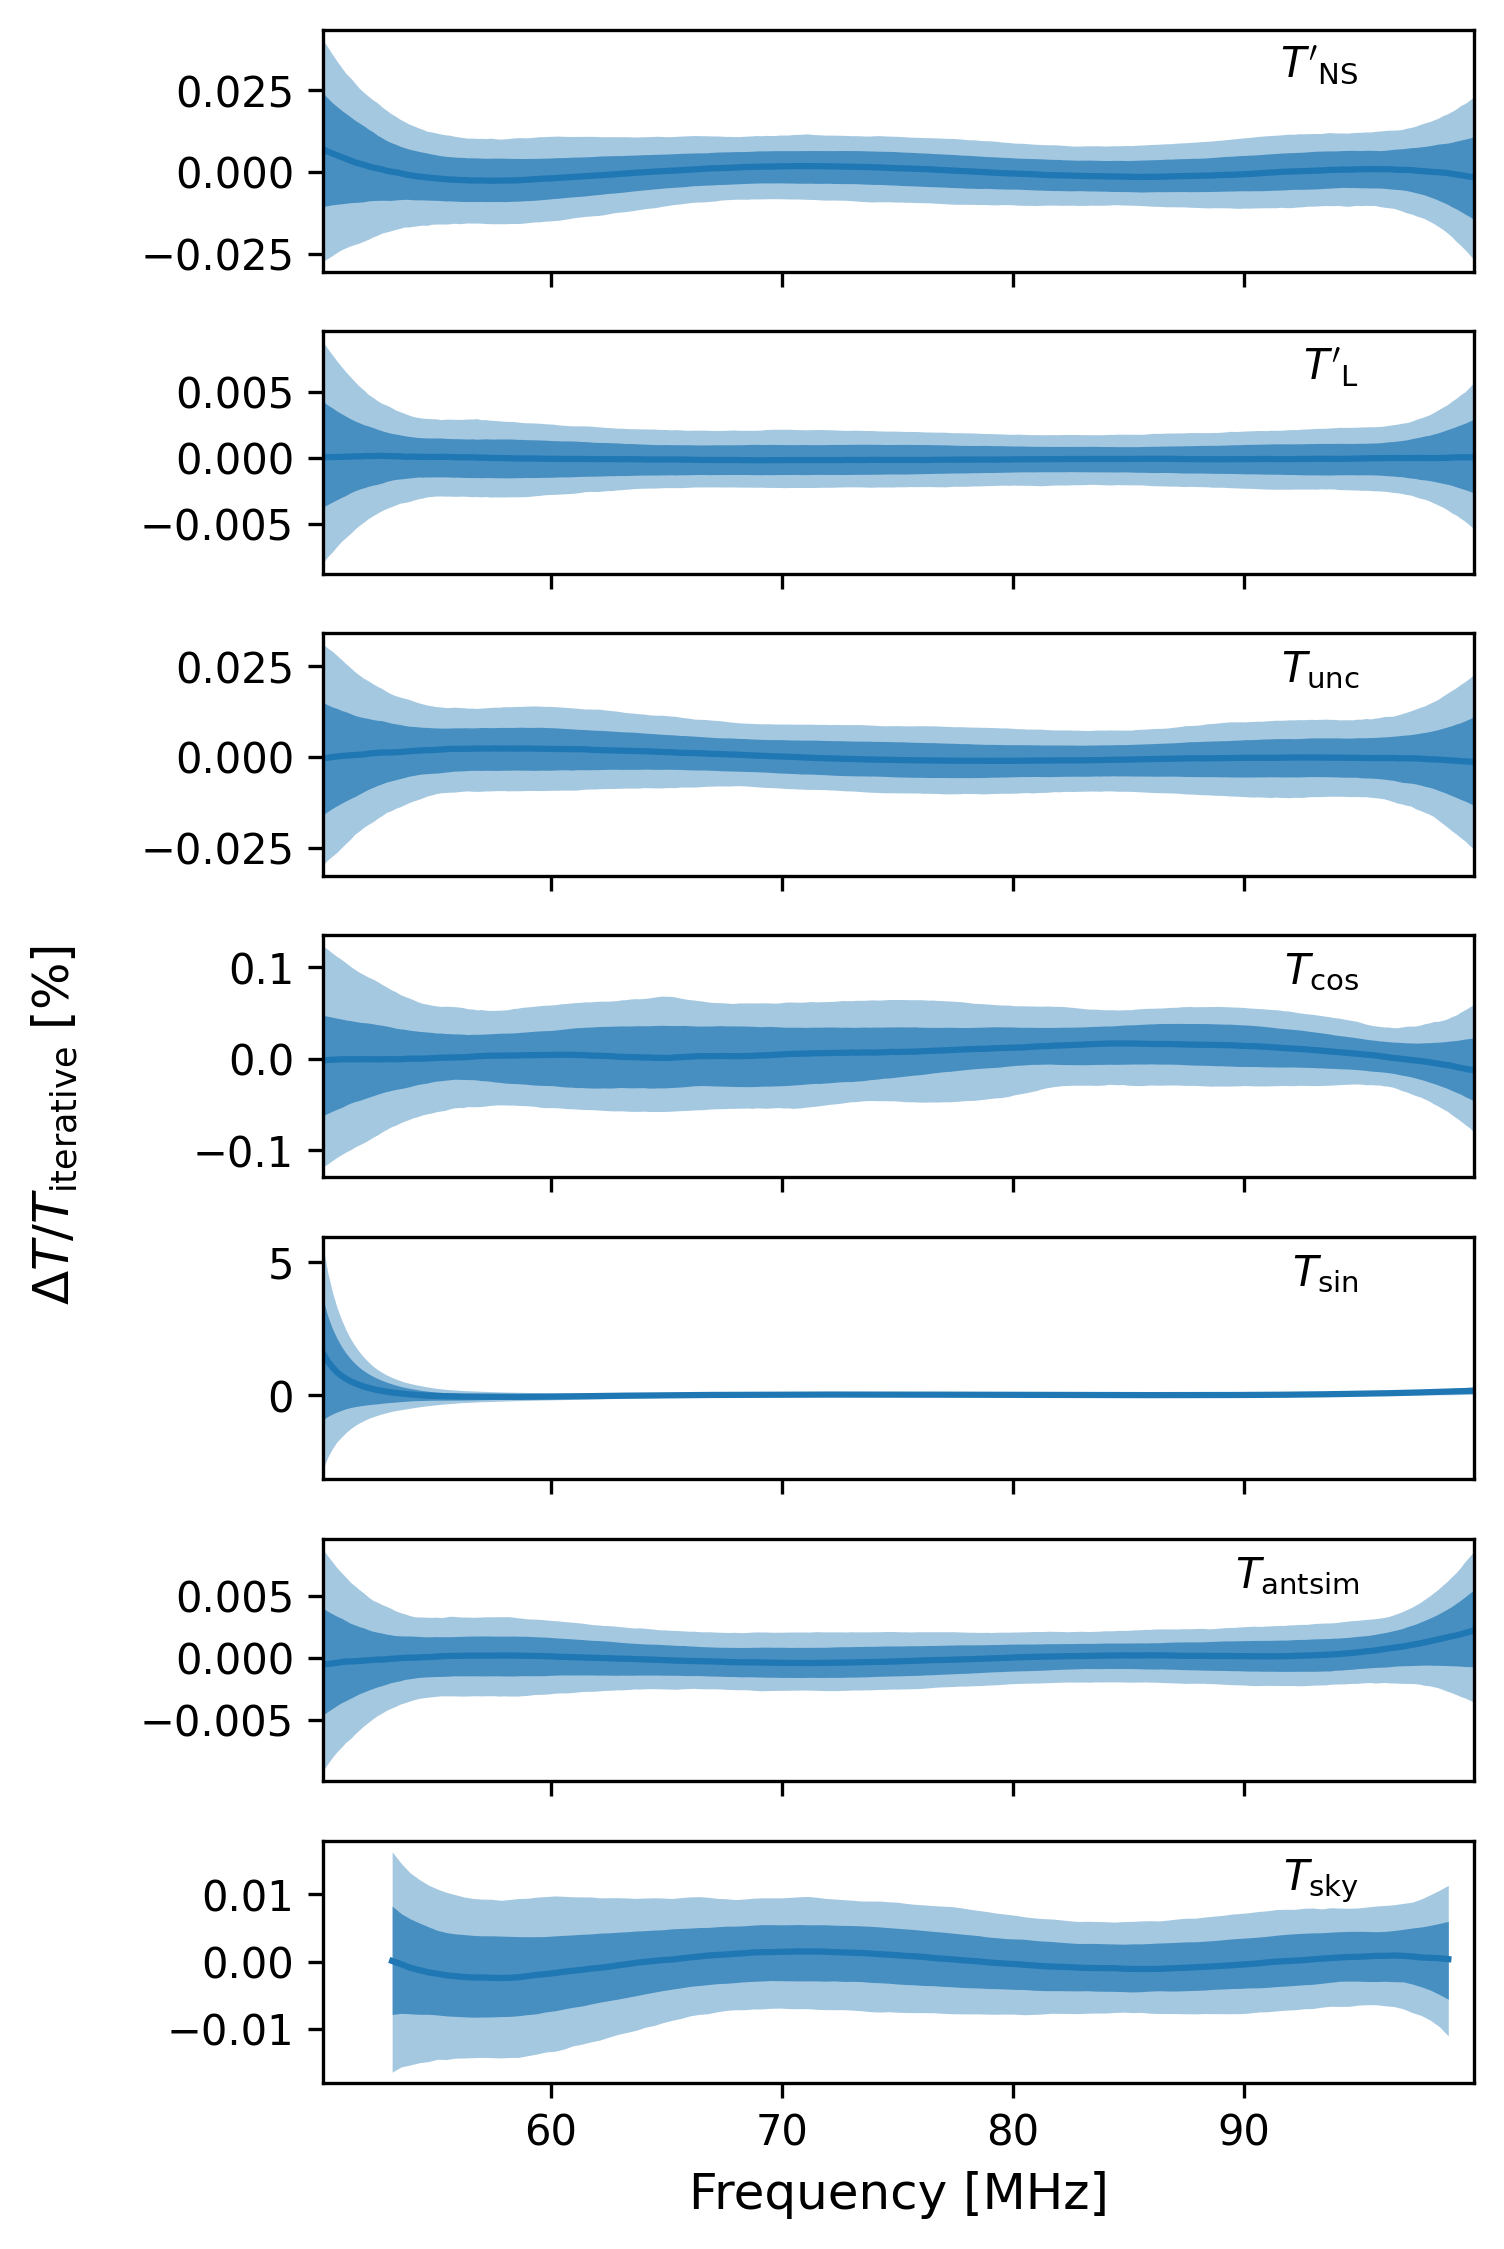

In [14]:
fig, ax = plt.subplots(7, 1, sharex=True, figsize=(1.5*nutl.single_width, 2.25*nutl.single_width))#, gridspec_kw={"wspace": 0.05, 'hspace': 0.05})

blob = cal_blobs['c06_w05_cf06_wf05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsim-False']

# Get recalibrated antenna simulator temp.
a, b = rcf.get_linear_coefficients(antsim32.s11_model(calobs32.freq.freq), calobs32.receiver.s11_model(calobs32.freq.freq), blob['tns']/1000, 300 - blob['tload'], blob['tunc'], blob['tcos'], blob['tsin'])
antsim_temp = antsim32.averaged_spectrum*a + b

# get recalibrated antenna temperatures
a, b = rcf.get_linear_coefficients(labcal32.antenna_s11_model(adata.sky_freq), 
                                   calobs32.receiver.s11_model(adata.sky_freq*u.MHz), 
                                   blob['tns_field']/1000, 300 - blob['tload_field'], blob['tunc_field'], blob['tcos_field'], blob['tsin_field'])
sky_temps = (calobs32.t_load_ns * a * adata.sky_q + a * 300 + b - adata.loss_temp) / (adata.bmcorr * adata.loss)


for i, key in enumerate(['Tns', 'Tload', 'Tunc', 'Tcos', 'Tsin']):
    p = np.percentile(blob[key.lower()], (2.5, 16, 50, 84, 97.5), axis=0)
    
    if key == 'Tns':
        fid = calobs32.C1() * calobs32.t_load_ns
    elif key == 'Tload':
        fid = calobs32.t_load - calobs32.C2()
    else:
        fid = getattr(calobs32, key)()
    
    p = 100*(p/fid - 1)
    
    lbl = {
        'Tns': r"$T'_{\rm NS}$",
        'Tload': r"$T'_{\rm L}$",
        "Tunc": r"$T_{\rm unc}$",
        "Tcos": r"$T_{\rm cos}$",
        "Tsin": r"$T_{\rm sin}$",
    }[key]
    
    ax[i].fill_between(calobs32.freq.freq, p[0], p[-1], alpha=0.4, color='C0', lw=0)
    ax[i].fill_between(calobs32.freq.freq, p[1], p[-2], alpha=0.7, color='C0', lw=0)
    ax[i].plot(calobs32.freq.freq, p[2], color='C0')
    ax[i].text(0.9, 0.8, lbl, transform=ax[i].transAxes,  horizontalalignment='right')
    ax[i].set_xlim(calobs32.freq.min.value, calobs32.freq.max.value)
        
# Now antsim
fid = calobs32.calibrate(antsim32)
p = np.percentile(antsim_temp, (2.5, 16, 50, 84, 97.5), axis=0)
p = 100*(p/fid - 1)
ax[-2].fill_between(calobs32.freq.freq, p[0], p[-1], alpha=0.4, color='C0', lw=0)
ax[-2].fill_between(calobs32.freq.freq, p[1], p[-2], alpha=0.7, color='C0', lw=0)
ax[-2].plot(calobs32.freq.freq, p[2], color='C0')
ax[-2].text(0.9, 0.8, r'$T_{\rm antsim}$', transform=ax[-2].transAxes,  horizontalalignment='right')
# Now antenna
fid = utils.recalibrate(labcal32, t_sky=adata.sky_temp,f_sky=adata.sky_freq)
p = np.percentile(sky_temps, (2.5, 16, 50, 84, 97.5), axis=0)
p = 100*(p/fid - 1)
ax[-1].fill_between(adata.sky_freq, p[0], p[-1], alpha=0.4, color='C0', lw=0)
ax[-1].fill_between(adata.sky_freq, p[1], p[-2], alpha=0.7, color='C0', lw=0)
ax[-1].plot(adata.sky_freq, p[2], color='C0')
ax[-1].text(0.9, 0.8, r'$T_{\rm sky}$', transform=ax[-1].transAxes,  horizontalalignment='right')
ax[-1].set_xlabel("Frequency [MHz]")
fig.supylabel(r"$\Delta T / T_{\rm iterative}$ [%]")
plt.tight_layout()

plt.savefig("plots/pure_calibration_regions.pdf")
